# SOAM Quickstart
How to make an end to end project using SOAM modules and tools.

This notebook pretends to show in a disaggregated manner how the methods and modules of the SoaM library works by taking as an example a model that predicts Apple's Stock Price Value for a pre-established time horizon. To see how these steps can be implemented more directly by leveraging the SoaM Flow power check the [soamflowrun notebook](notebook/examples/soamflowrun.ipynb).

This library pipeline supports any data source.
The process is structured in different stages:
* Extraction: manages the connection with the database, the time granularity and the aggregation level of the input data.
* Preprocessing: lets you select among out of the box tools to perform standard tasks such as normalization or fill nan values.
* Forecasting: fits a model and predict results.
* Postprocessing: modifies the results based on business/real information or create analysis with the predicted values.
* Plotting and Reporting: generates plots and automates reports such as sending a mail or a message to a slack group.



## Extraction
First of all we need the data, this stage takes care of that by extracting our data from the needed sources to build the condensed dataset for the next steps. This tends to be project dependent.

Steps in this section: <br>

1. DB Connection using `muttlib`. <br>
2. `SOAM Extractor` object initialization.
3. `SQL Query` constructed <br>
4. `Extractor.run` method executed to extract the data from the DB based on the specified query and save it as a `pandas.DataFrame` object.

1) DB Connection using `muttlib`. We have to set up the postgres config and then retrieve it using the muttlib's `get_client()` method.

*Note: we already have our training data loaded in a postgres database named sqlalchemy*

In [1]:
from soam.workflow.time_series_extractor import TimeSeriesExtractor
from muttlib.dbconn import get_client

In [2]:
pg_cfg = {
    "host": "localhost",
    "port": 5432,
    "db_type": "postgres",
    "username": "mutt",
    "password": "mutt",
    "database": "sqlalchemy"
}

pg_client = get_client(pg_cfg)[1]

2) `SOAM Extractor` object initialization with the postgres client of our DB and the table name given as input.

In [3]:
extractor = TimeSeriesExtractor(db=pg_client, table_name='stocks_valuation')

3) `SQL Query` constructed using a dictionary to set the configuration of the extraction query. The idea is to convert the full dataset to the desired time granularity and aggregation level by some categorical attribute/s.

In this case we define the following: <br>
- Time granularity: <br>
     - Start date: 2021-03-01 <br>
     - End date: 2021-03-20
- Aggregation Level:
    - Order the date ascendantly.
    - Just stay with Apple's (AAPL) stock information.


*Note: The `build_query_kwargs` is a dictionary that sets the configuration of the extraction query to be used for the extraction. To see further options on how to build more complex queries check the `TimeSeriesExtractor` documentation by executing `??TimeSeriesExtractor`*

In [4]:
build_query_kwargs={
    'columns': '*',
    'timestamp_col': 'date',
    'start_date': "2021-03-01",
    'end_date': "2021-03-20",
    'extra_where_conditions': ["symbol = 'AAPL'"],
    'order_by': ["date ASC"]
}

4) `Extractor.run` method executed to extract the data from the DB based on the specified query *(given as a parameter)* and save it as a `pandas.DataFrame` object to facilitate data manipulation.


In [5]:
import pandas as pd
df = extractor.run(build_query_kwargs = build_query_kwargs)

df.head()

,index,date,symbol,avg_num_trades,avg_price
0,13,2021-03-01,AAPL,80769.369444,125.3600
1,12,2021-03-02,AAPL,71014.545139,126.8650
2,11,2021-03-03,AAPL,78448.847222,123.7750
3,10,2021-03-04,AAPL,123718.732639,121.1100
4,9,2021-03-05,AAPL,106782.361806,119.7525


Voilà!

## Preprocessing

Now that we have our dataframe loaded, it's time to preprocess the data to our desired shape and state.

Steps in this section:

1. `SOAM Transformer` object initialization. <br>
2. Custom transformations made to set the dataframe to the desired format. <br>
3. `Transformer.run` method execution to scale the data with the selected method.

1) Create the Transformer object and pass the scaler as the transformer parameter. In this case we are using the `MinMaxScaler()` from the `sklearn.preprocessing` library.

In [6]:
from soam.workflow import Transformer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ts = Transformer(transformer = scaler)

2) Custom transformations: We want to normalize the average price values.

2.1) We convert the column to an array and swap the axes to pass it to the scaler.

In [7]:
import numpy as np
data = np.array([df.avg_price])
data = np.swapaxes(data, 0, 1)

2.2) We drop the unnecesary columns and adapt the column names for the Fb Prophet for the Forecasting.


2.3) We need a `ds` column of type DateTime to indicate the moment of observation in the time series and a `y` column for it's value.

In [8]:
df = df[['date', 'avg_price']]
df.rename(columns = {
    'date': 'ds',
    'avg_price': 'y'}, inplace = True)
df.ds =  pd.to_datetime(df.ds, infer_datetime_format=True)
df.head()

,ds,y
0,2021-03-01,125.3600
1,2021-03-02,126.8650
2,2021-03-03,123.7750
3,2021-03-04,121.1100
4,2021-03-05,119.7525


3) `Transformer.run` method executed to scale the data with the `MinMaxScaler()` method.

In [9]:
df.y = ts.run(data)[0]
df.head()

,ds,y
0,2021-03-01,0.817797
1,2021-03-02,1.000000
2,2021-03-03,0.625908
3,2021-03-04,0.303269
4,2021-03-05,0.138923


Voilà!

## Forecasting

Now that we have our training data already clean it's time to fit our model and forecast future values! For this we use `SoaM Wrappers` to wrap our selected model.

In this example we will use the [fbprophet](https://facebook.github.io/prophet/) model.

Steps in this section:

1. Forecasting object initialization. <br>
2. `SOAM Forecaster` object initialization.
3. `Forecaster.run` method executed to forecast our time-series.

1) Forecasting object initialization, we selected `FbProphet` as a forecasting method and we set to `False` the seasonality calculations for simplicity. <br>

In [10]:
%%capture #hide

from soam.models import SkProphet
my_model = SkProphet(weekly_seasonality=False, daily_seasonality=False)

2) `SOAM Forecaster` object initialization and pass the forecasting model to the constructor. 

In [11]:
from soam.workflow.forecaster import Forecaster
forecaster = Forecaster(my_model, output_length=7)

3) `Forecaster.run` method executed to forecast our time-series.

Now we use the `run` method of the forecaster instance that we just created to fit the model to the data and make a prediction.  

The `run` method requires as input a Pandas DataFrame with at least a `ds` column of type DateTime to indicate the moment of observation in the time series and a `y` column for it's value.  
[`Multivariate`](https://unit8co.github.io/darts/generated_api/darts.models.forecasting_model.html#darts.models.forecasting_model.MultivariateForecastingModel) models also accept other timeseries appart from the one in the `y` column we just mentioned. 

Note that both prediction and trained model will be initially stored as attributes of the `Forecaster` instance.

The output length parameter is passed to indicate the number of points that we want to predict in the future.

In the `add_future_dates` method, the amount of periods to predict is passed as a parameter as well as the frequency (time granularity) of those periods. In this case we use 7 days.

*Note that some models may fails if output length is larger than input length.*


In [12]:
%%capture #hide

from soam.utilities.utils import add_future_dates
df = add_future_dates(df, periods=7, frequency="d")
predictions, time_series, model = forecaster.run(time_series=df)

As you can see, the `forecaster.run` method returns a tuple of:

- Predictions dataset. <br>
- Time series dataset (training set used with the future dates). <br>
- Fitted model.

In [13]:
(predictions.head(), time_series.head(), model)

(          ds      yhat
 0 2021-03-19  0.403346
 1 2021-03-20  0.397717
 2 2021-03-21  0.392087
 3 2021-03-22  0.386457
 4 2021-03-23  0.380827,
           ds         y
 0 2021-03-01  0.817797
 1 2021-03-02  1.000000
 2 2021-03-03  0.625908
 3 2021-03-04  0.303269
 4 2021-03-05  0.138923,
 SkProphet(daily_seasonality=False, fit_params={}, weekly_seasonality=False))

Voilà!

## Plotting
Now that we have our predictions, let's plot the results to compare the predicted values with the expected ones visually!

Steps in this section:

1. Import the `plot_configs`.
2. `ForecastPlotterTask` object initialization.
3. `ForecastPlotterTask.run` execution to plot the figure.

In [14]:
from soam.plotting.forecast_plotter import ForecastPlotterTask
from soam.constants import PLOT_CONFIG
from copy import deepcopy
from pathlib import Path

1) Import the `plot_configs`. <br>
2) `ForecastPlotterTask` object initialization to whom we give as parameters: 
- the `Path` object where we want to save the file,
- the name of the metric being analyzed, *Apple's Stock Price* in this case,
- and the plot configs that are obtained through the `PLOT_CONFIG` constant.

In [15]:
plot_config = deepcopy(PLOT_CONFIG)
forecast_plotter = ForecastPlotterTask(path = Path('img/applestockprice'), metric_name = "Apple's Stock Price", plot_config = plot_config)

3) `ForecastPlotterTask.run` execution to plot the figure.

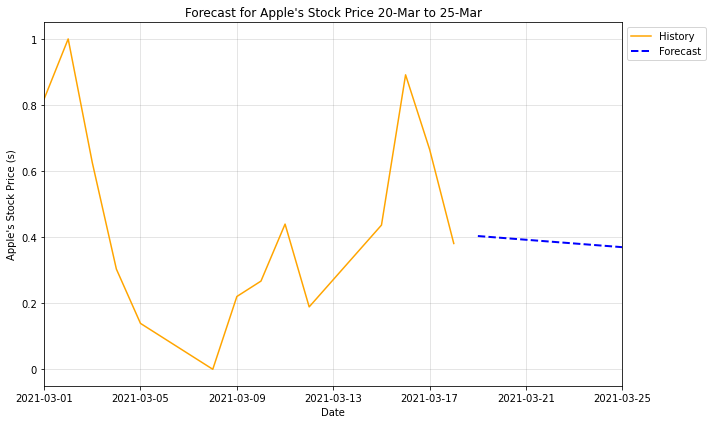

In [16]:
plot_fn = forecast_plotter.run(forecaster.time_series, forecaster.prediction)

Voilà!

## Postprocessing
Let's now focus on the things we can do once the analysis is done.

###  Mail Report

Ok. Everything is done, let's now share our results with the rest of the team by sending an email to them!

The class `MailReport` has everything you need for sending an email report, you'll just need a SMTP enabled email account. 

Your gmail account should have 2FA (Two-Factor Authentication) and Third-Party apps permissions active, with that you'll be able to create an App Pasword for your smtp settings. [Official Gmail guide](https://support.google.com/mail/answer/185833?hl=en)

Make sure to add your SMTP credentials to `settings.ini` *(located in the root file of your project)*. If using a Gmail account, you won't have to modify the `SMTP_HOST` and `SMTP_PORT`.

*Note that you can find a sample `settings.ini` file in your generated package root `your-project-name/settings_sample.ini` *

Steps in this section:

1. `SOAM Mail Report` object initialization.
2. `MailReportTask.run` execution to send the email.

1) `SOAM Mail Report` object initialization and definition of its parameters:
- list of mails that will receive the report.
- name of the metric being analyzed.

In [17]:
from soam.reporting import mail_report
mr = mail_report.MailReportTask(
    # recipients mails separated by commas
    mail_recipients_list = ["mail@gmail.com"],
    # the metric name will be in the title
    metric_name = "Apple's Stock Price" 
)

2) `MailReportTask.run` execution to send the email and definition of its parameters:
- start_date and end_date as strings with *yyyymmddhh* format.
- current_date as string with *yyyy-mm-dd* format.
- plot_filename showing the relative path of the plot.

In [18]:
%%capture #hide

start_date='2021030100'
end_date='2021031900'
mr.run(
    current_date = "2021-04-12",
    plot_filename = f'img/applestockprice/0_forecast_{start_date}_{end_date}_.png'
)

### Email sent

Screenshot of the email received.

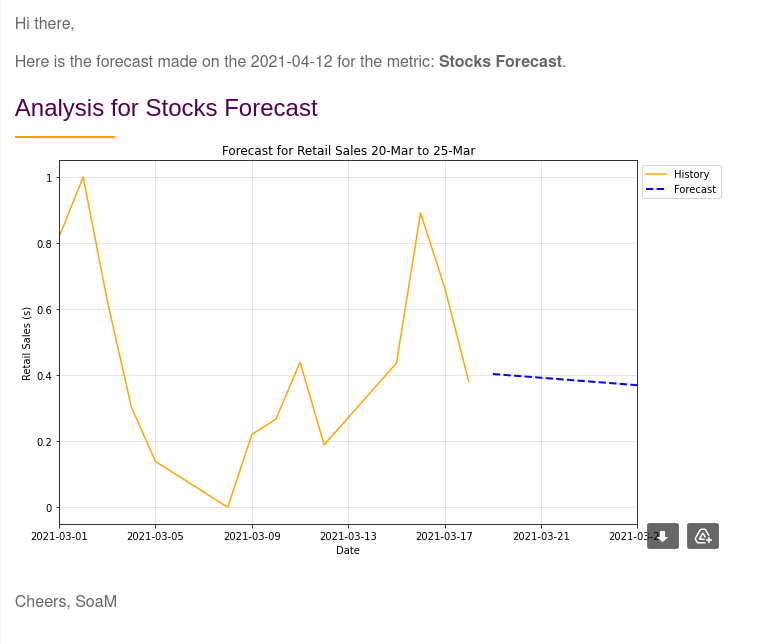

In [19]:
from IPython.display import display, Image

display(Image(filename='img/emailreport_apple.png'))

Voilà!